# T005 · Compound clustering

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Gizem Spriewald, CADD Seminar, 2017, Charité/FU Berlin
- Calvinna Caswara, CADD Seminar, 2018, Charité/FU Berlin
- Jaime Rodríguez-Guerra, 2019-2020, [Volkamer lab](https://volkamerlab.org), Charité

__Talktorial T005__: This talktorial is part of the TeachOpenCADD pipeline described in the [first TeachOpenCADD paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x), comprising of talktorials T001-T010.

## Aim of this talktorial

<!-- TODO: The wording of this paragraph is confusing -->

Similar compounds might bind to the same targets and show similar effects. 
Based on this similar property principle, compound similarity can be used to build chemical groups via clustering. 
From such a clustering, a diverse set of compounds can also be selected from a larger set of screening compounds for further experimental testing.

### Contents in _Theory_

* Introduction to clustering and Jarvis-Patrick algorithm
* Detailed explanation of Butina clustering
* Picking diverse compounds

### Contents in _Practical_

* Clustering with the Butina algorithm
* Visualizing the clusters
* Picking the final list of compounds
* Bonus: analysis of run times

### References

* Butina, D. Unsupervised Data Base Clustering Based on Daylight’s Fingerprint and Tanimoto Similarity: A Fast and Automated Way To Cluster Small and Large Data Set. _J. Chem. Inf. Comput. Sci._ (1999)
* Leach, Andrew R., Gillet, Valerie J. An Introduction to Chemoinformatics (2003)
* [Jarvis-Patrick Clustering](http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/Jarvis-Patrick_Clustering_Overview.htm)
* [TDT Tutorial](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb)
* [RDKit clustering documentation](http://rdkit.org/docs/Cookbook.html#clustering-molecules)

## Theory

### Introduction to clustering and Jarvis-Patrick algorithm

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) can be defined as _the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters)_.

Compound clustering in pharmaceutical research is often based on chemical or structural similarity between compounds to find groups that share properties as well as to design a diverse and representative set for further analysis. 

General procedure: 

* Methods are based on clustering data by similarity between neighboring points. 
* In cheminformatics, compounds are often encoded as molecular fingerprints and similarity can be described by the Tanimoto similarity (see **Talktorial T004**).

> Quick reminder:
> 
>   * Fingerprints are binary vectors where each bit indicates the presence or absence of a particular substructural fragment within a molecule. 
>   * Similarity (or distance) matrix: The similarity between each pair of molecules represented by binary fingerprints is most frequently quantified using the Tanimoto coefficient, which measures the number of common features (bits). 
>   * The value of the Tanimoto coefficient ranges from zero (no similarity) to one (high similarity).

There are a number of clustering algorithms available, with the [Jarvis-Patrick clustering](http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/Jarvis-Patrick_Clustering_Overview.htm) being one of the most widely used algorithms in the pharmaceutical context.

Jarvis-Patrick clustering algorithm is defined by two parameters $K$ and $K_{min}$:

* Calculate the set of $K$ nearest neighbors for each molecule. 
* Two molecules cluster together if 
    * they are in each others list of nearest neighbors
    * they have at least $K_{min}$ of their $K$ nearest neighbors in common.

The Jarvis-Patrick clustering algorithm is deterministic and able to deal with large sets of molecules in a matter of a few hours. However, a downside lies in the fact that this method tends to produce large heterogeneous clusters (see _Butina clustering_, referenced above). 

More clustering algorithms can also be found in the [scikit-learn clustering module](http://scikit-learn.org/stable/modules/clustering.html).

### Detailed explanation of Butina clustering

Butina clustering ([*J. Chem. Inf. Model.* (1999), **39** (4), 747](https://pubs.acs.org/doi/abs/10.1021/ci9803381)) was developed to identify smaller but homogeneous clusters, with the prerequisite that (at least) the cluster centroid will be more similar than a given threshold to every other molecule in the cluster.

These are the key steps in this clustering approach (see flowchart below):

#### 1. Data preparation and compound encoding

* To identify chemical similarities, the compounds in the input data (e.g. given as SMILES) will be encoded as molecular fingerprints, e.g., RDK5 fingerprint which is a subgraph-based fingerprint similar to the well known [Daylight Fingerprint](http://www.daylight.com/dayhtml/doc/theory/theory.finger.html) (which was used in the original publication).


#### 2. Tanimoto similarity (or distance) matrix

* The similarity between two fingerprints is calculated using the Tanimoto coefficient.
* Matrix with Tanimoto similarities between all possible molecule/fingerprint pairs ($n*n$ similarity matrix with $n$=number of molecules, upper triangle matrix used only).
* Equally, the distances matrix can be calculated ($1 - similarity$).

#### 3. Clustering molecules: Centroids and exclusion spheres 

> Note: Molecules will be clustered together, if they have a maximum distance below a specified cut-off from the cluster centroid (if distance matrix is used) or if they have a minimum similarity above the specified cut-off (if similarity matrix is used).  

* **Identification of potential cluster centroids**
    * The cluster centroid is the molecule within a given cluster which has the largest number of neighbors.
    * Annotate neighbors: For each molecule count all molecules with a Tanimoto distance below a given threshold.
    * Sort the molecules by their number of neighbors in descending order, so that potential cluster centroids (i.e. the compounds with the largest number of neighbors) are placed at the top of the file.  

* **Clustering based on the exclusion spheres**
    * Starting with the first molecule (centroid) in the sorted list.
        * All molecules with a Tanimoto index above or equal to the cut-off value used for clustering then become members of that cluster (in case of similarity).
            * Each molecule that has been identified as a member of the given cluster is flagged and removed from further comparisons. Thus, flagged molecules cannot become either another cluster centroid or a member of another cluster. This process is like putting an exclusion sphere around the newly formed cluster.
            * Once the first compound in the list has found all its neighbors, the first available (i.e. not flagged) compound at the top of the list becomes the new cluster centroid.
        * The same process is repeated for all other unflagged molecules down the list.
    * Molecules that have not been flagged by the end of the clustering process become singletons.
        * Note that some molecules assigned as singletons can have neighbors at the given Tanimoto similarity index, but those neighbors have been excluded by a stronger cluster centroid.

In [1]:
from IPython.display import IFrame

IFrame("images/butina_full.pdf", width=800, height=500)

*Figure 1:* Theoretical example of the Butina clustering algorithm, drawn by Calvinna Caswara.

### Picking diverse compounds

Finding representative sets of compounds is a concept often used in pharmaceutical industry.

* Let's say, we applied a virtual screening campaign but only have a limited amount of resources to experimentally test a few compounds in a confirmatory assay.  
* In order to obtain as much information as possible from this screen, we want to select a diverse set. Thus, we pick one representative of each chemical series in our list of potentially active compounds.

Another scenario would be to select one series to gain information about the structure-activity relationship; i.e., how small structural changes in the molecule affect the _in vitro_ activity.

## Practical

### Clustering with the Butina algorithm

Application is following the example of the [TDT tutorial notebook by S. Riniker and G. Landrum](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb).

#### Load data and calculate fingerprints
In this part the data is prepared and fingerprints are calculated.

In [3]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

#from teachopencadd.utils import seed_everything

#seed_everything()  # fix seed to get deterministic outputs

In [4]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [5]:
# Load and have a look into data
# Filtered data taken from **Talktorial T002**
compound_df = pd.read_csv(
    HERE / "../T002_compound_adme/data/EGFR_compounds_lipinski.csv",
    index_col=0,
)
print("Dataframe shape:", compound_df.shape)
compound_df.head()

Dataframe shape: (4635, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True


In [6]:
# Create molecules from SMILES and store in array
compounds = []
# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
for _, chembl_id, smiles in compound_df[["molecule_chembl_id", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x7f40041bf0a0>, 'CHEMBL63786'),
 (<rdkit.Chem.rdchem.Mol at 0x7f3fb86f5a00>, 'CHEMBL35820'),
 (<rdkit.Chem.rdchem.Mol at 0x7f3fb86f5700>, 'CHEMBL53711'),
 (<rdkit.Chem.rdchem.Mol at 0x7f3fb86f5be0>, 'CHEMBL66031'),
 (<rdkit.Chem.rdchem.Mol at 0x7f3fb86f5ca0>, 'CHEMBL53753')]

In [7]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))
# NBVAL_CHECK_OUTPUT

Number of compounds converted: 4635
Fingerprint length per compound: 2048


#### Tanimoto similarity and distance matrix
Now that we generated fingerprints, we move on to the next step: The identification of potential cluster centroids.  For this, we define functions to calculate the Tanimoto similarity and distance matrix.

In [8]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

See also [[Rdkit-discuss] BulkTanimotoSimilarity](https://sourceforge.net/p/rdkit/mailman/rdkit-discuss/thread/663770d4-b809-c599-e379-31f57380a1d0%40gmail.com/#msg36335970).

In [9]:
# Example: Calculate single similarity of two fingerprints
# NBVAL_CHECK_OUTPUT
sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.73, distance: 0.27


In [10]:
# Example: Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(fingerprints)[0:5]

[0.26996197718631176,
 0.26538461538461533,
 0.40866873065015474,
 0.09345794392523366,
 0.31182795698924726]

In [11]:
# Side note: That looked like a list and not a matrix.
# But it is a triangular similarity matrix in the form of a list
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance_matrix(fingerprints))})",
)
# NBVAL_CHECK_OUTPUT

Elements in the triangular matrix (10739295) == tanimoto_distance_matrix(fingerprints) (10739295)


#### Clustering molecules: Centroids and exclusion spheres
In this part, we cluster the molecules and look at the results.

Define a clustering function.

In [12]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

Cluster the molecules based on their fingerprint similarity.

In [13]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.3)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)
# NBVAL_CHECK_OUTPUT

total # clusters:  727
# clusters with only 1 compound:  339
# clusters with >5 compounds:  164
# clusters with >25 compounds:  30
# clusters with >100 compounds:  4


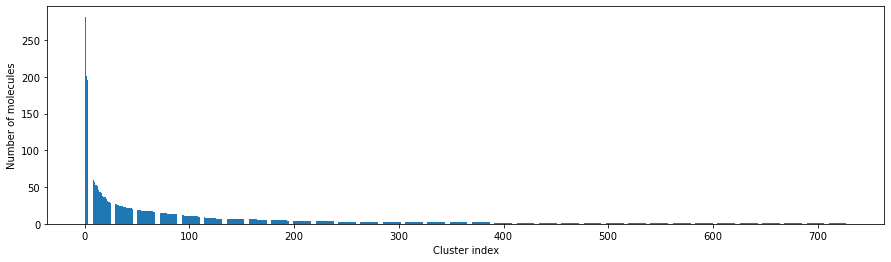

In [14]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

#### How to pick a reasonable cutoff?
Since the clustering result depends on the threshold chosen by the user, we will have a closer look on the choice of a cutoff.

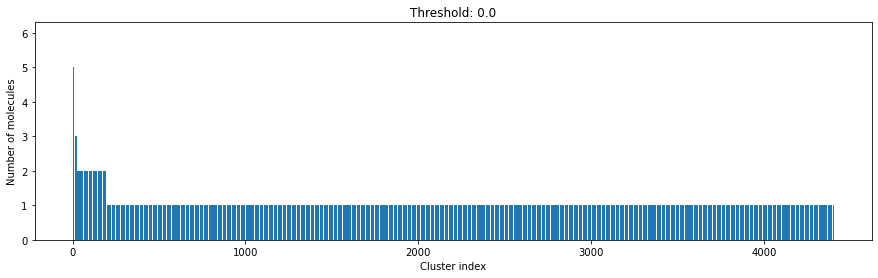

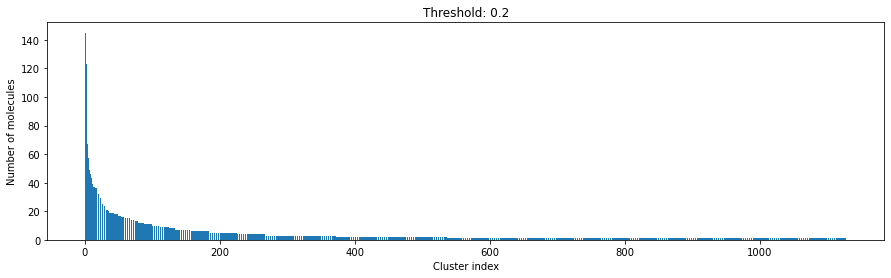

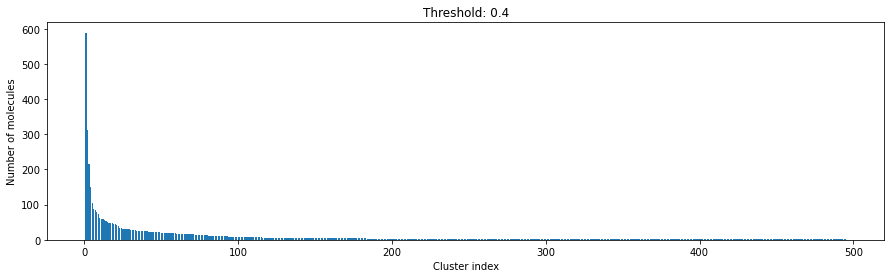

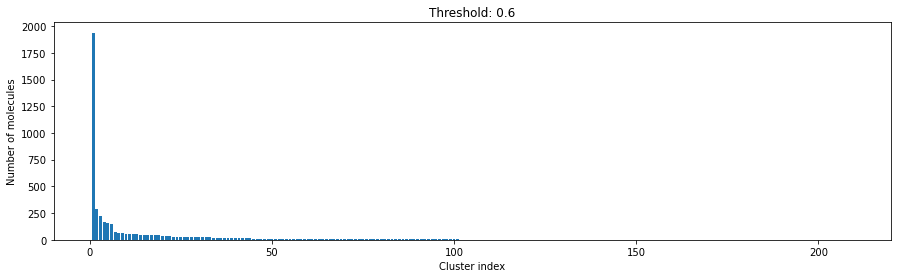

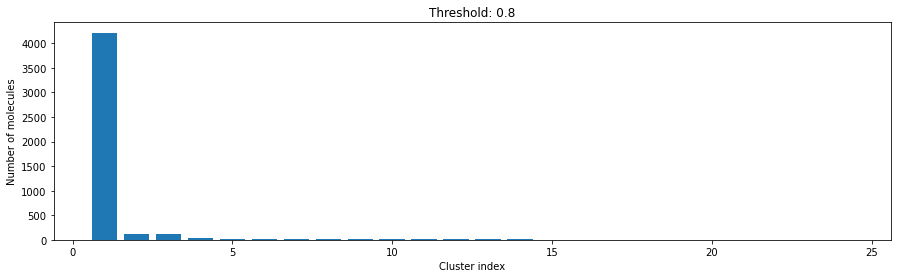

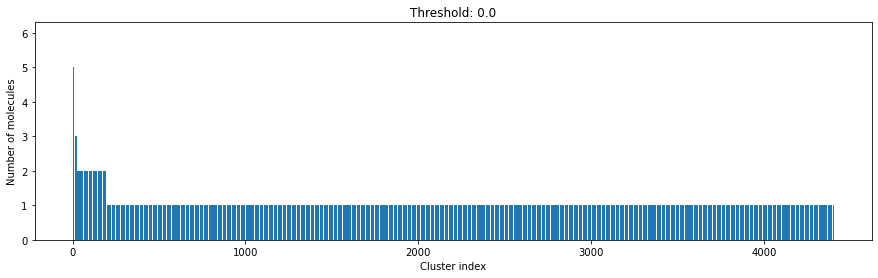

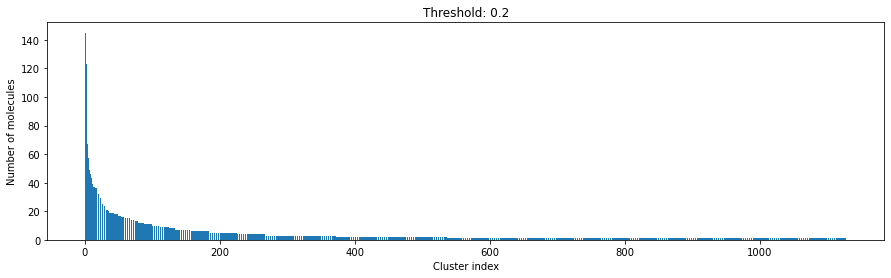

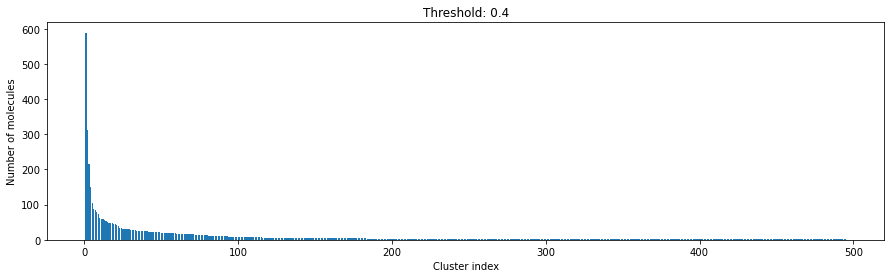

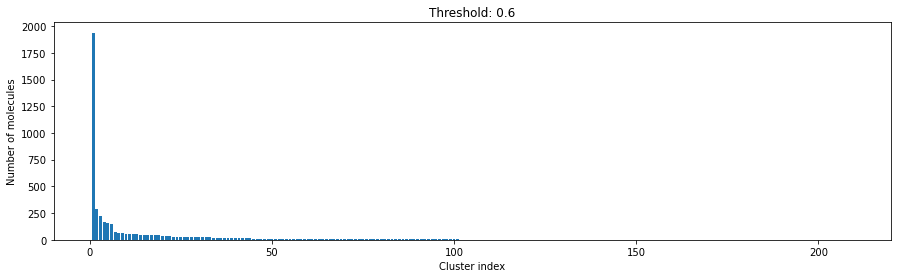

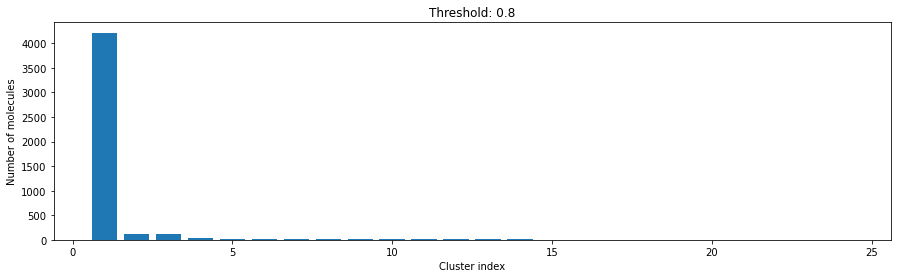

In [15]:
for cutoff in numpy.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

As you can see, the higher the threshold (distance cutoff), the more molecules are considered as similar and, therefore, clustered into less clusters.
The lower the threshold, the more small clusters and "singletons" appear.

> The smaller the distance value cut-off, the more similar the compounds are required to be to belong to one cluster.

Looking at the plots above, we decided to choose a distance threshold of `0.2`. There are not many singletons and the cluster sizes don't have an extreme but smooth distribution.

Number of clusters: 1128 from 4635 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 145
Similarity between two random points in same cluster: 0.82
Similarity between two random points in different cluster: 0.22


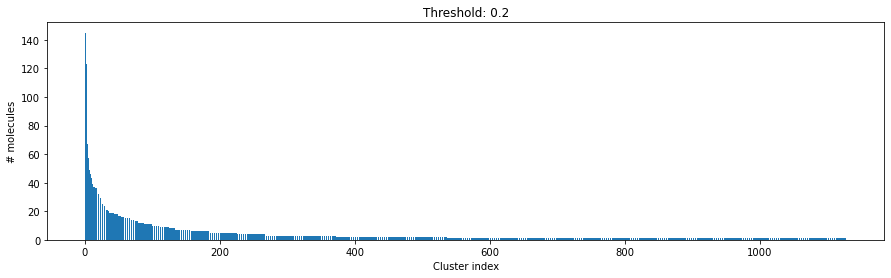

In [16]:
cutoff = 0.2
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")
fig.savefig(
    DATA / f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

### Visualizing the clusters

#### 10 examples from largest cluster

Now, let's have a closer look at the first 10 molecular structures of the first/largest clusters.

Ten molecules from largest cluster:


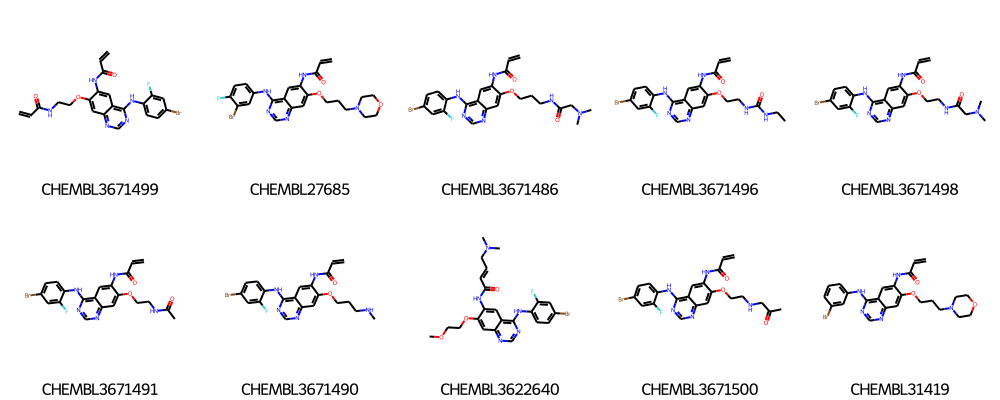

In [17]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:10]],
    legends=[compounds[i][1] for i in clusters[0][:10]],
    molsPerRow=5,
)

In [18]:
# Save molecules from largest cluster so other talktorials can use it
sdf_path = str(DATA / "molecule_set_largest_cluster.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters[0]:
    mol, label = compounds[index]
    # Add label to metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)
sdf.close()

#### 10 examples from second largest cluster

Ten molecules from second largest cluster:


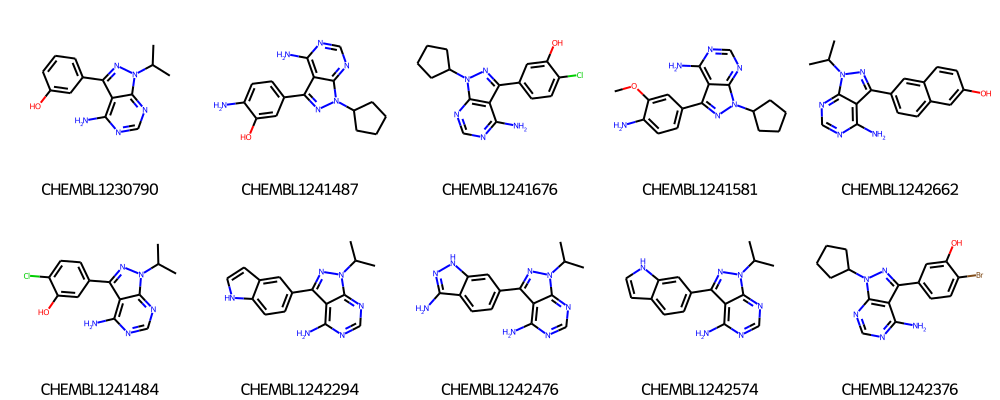

In [19]:
print("Ten molecules from second largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[1][:10]],
    legends=[compounds[i][1] for i in clusters[1][:10]],
    molsPerRow=5,
)

The first ten molecules in the respective clusters look indeed similar to each other and many share a common scaffold (visually detected). 

See **Talktorial T006** for more information on how to calculate the maximum common substructure (MCS) of a set of molecules.

#### Examples from first 10 clusters

For comparison, we have a look at the cluster centers of the first 10 clusters.

Ten molecules from first 10 clusters:


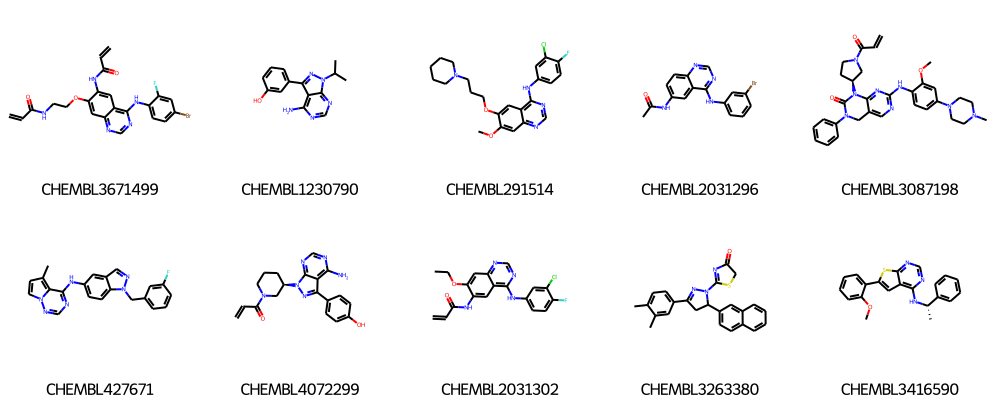

In [20]:
print("Ten molecules from first 10 clusters:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(10)],
    legends=[compounds[clusters[i][0]][1] for i in range(10)],
    molsPerRow=5,
)

Save cluster centers from first 3 clusters as SVG file.

In [21]:
# Generate image
img = Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(0, 3)],
    legends=[f"Cluster {i}" for i in range(1, 4)],
    subImgSize=(200, 200),
    useSVG=True,
)

# Patch RAW svg data: convert non-transparent to transparent background and set font size
molsvg = img.data.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open(DATA / "cluster_representatives.svg", "w") as f:
    f.write(molsvg)

While still some similarity is visible, clearly, the centroids from the different clusters look more dissimilar then the compounds within one cluster.

#### Intra-cluster Tanimoto similarities

We can also have a look at the intra-cluster Tanimoto similarities.

In [22]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [23]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

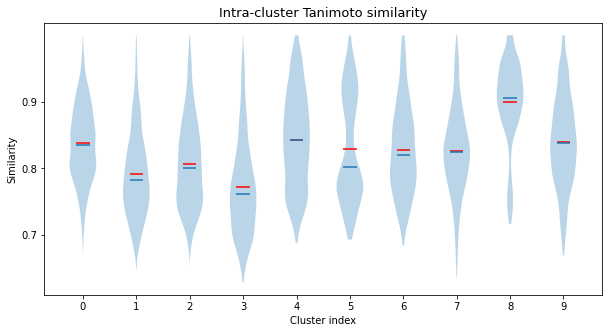

In [24]:
# Violin plot with intra-cluster similarity

fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(numpy.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue

### Picking the final list of compounds

In the following, we are going to pick a final list of **max. 1000 compounds** as a **diverse** subset. 

For this, we take the cluster centroid from each cluster (i.e. the first molecule of each cluster) and then for each cluster (starting with the largest one) we take the 10 molecules (or 50% if less than 10 molecules are left in the cluster) that are most similar to the centroid, until we have selected max. 1000 compounds. Thus, we have representatives of each cluster. 

Aim of this compound picking is to ensure the diversity for a smaller set of compounds which are proposed for testing in a confirmatory assay. 

> Picking procedure was adapted from [TDT tutorial notebook by S. Riniker and G. Landrum](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb). 

As described there: the idea behind this approach is to ensure diversity (representatives of each cluster) while getting some SAR (structure-activity relationship) from the results of the confirmatory assay (groups of quite similar molecules from larger clusters retained).

Get cluster centers.

In [25]:
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [compounds[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))
# NBVAL_CHECK_OUTPUT

Number of cluster centers: 1128


Sort clusters by size and molecules in each cluster by similarity.

In [26]:
# Sort the molecules within a cluster based on their similarity
# to the cluster center and sort the clusters based on their size
sorted_clusters = []
for cluster in clusters:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    sorted_fingerprints = [rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)

Pick a maximum of 1000 compounds.

In [27]:
# Count selected molecules, pick cluster centers first
selected_molecules = cluster_centers.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
pending = 1000 - len(selected_molecules)
while pending > 0 and index < len(sorted_clusters):
    # Take indices of sorted clusters
    tmp_cluster = sorted_clusters[index][1]
    # If the first cluster is > 10 big then take exactly 10 compounds
    if sorted_clusters[index][0] > 10:
        num_compounds = 10
    # If smaller, take half of the molecules
    else:
        num_compounds = int(0.5 * len(tmp_cluster)) + 1
    if num_compounds > pending:
        num_compounds = pending
    # Write picked molecules and their structures into list of lists called picked_fps
    selected_molecules += [compounds[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    pending = 1000 - len(selected_molecules)
print("# Selected molecules:", len(selected_molecules))
# NBVAL_CHECK_OUTPUT

# Selected molecules: 1128


This set of diverse molecules could now be used for experimental testing.

### Bonus: analysis of run times

At the end of the talktorial, we can play with the size of the dataset and see how the Butina clustering run time changes.

In [28]:
# Reuse old dataset
sampled_mols = compounds.copy()

Note that you can try out larger datasets, but data sizes larger than 10000 data points already start to consume quite some memory and time (that's why we stopped there). 

In [29]:
# Helper function for time computation
def measure_runtime(sampled_mols):
    start_time = time.time()
    sampled_fingerprints = [rdkit_gen.GetFingerprint(m) for m, idx in sampled_mols]
    # Run the clustering with the dataset
    sampled_clusters = cluster_fingerprints(sampled_fingerprints, cutoff=0.3)
    return time.time() - start_time

In [30]:
len(sampled_mols)
# NBVAL_CHECK_OUTPUT

4635

In [31]:
sample_sizes = [100, 500, 1000, 2000, 4000]
runtimes = []
# Take random samples with replacement
for size in sample_sizes:
    time_taken = measure_runtime(random.sample(sampled_mols, size))
    print(f"Dataset size {size}, time {time_taken:4.2f} seconds")
    runtimes.append(time_taken)

Dataset size 100, time 0.07 seconds
Dataset size 500, time 0.39 seconds
Dataset size 1000, time 0.89 seconds
Dataset size 2000, time 2.08 seconds
Dataset size 4000, time 6.09 seconds


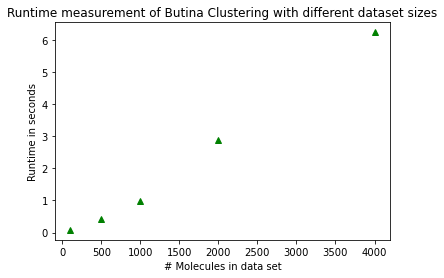

In [31]:
fig, ax = plt.subplots()
ax.set_title("Runtime measurement of Butina Clustering with different dataset sizes")
ax.set_xlabel("# Molecules in data set")
ax.set_ylabel("Runtime in seconds")
ax.plot(sample_sizes, runtimes, "g^");

Notice how the runtime is not exactly proportional to the sample size! It grows faster!

## Discussion

We have introduced the Butina algorithm to cluster a compound dataset and discussed how to pick a reasonable clustering threshold. The clustering was rationalized by looking at example compounds from different clusters and by checking intra-cluster similarities. Finally, the clusters were used to pick a divers subset of compounds.

## Quiz
* Why is clustering of molecules important?
* Which algorithms can you use to cluster a set of molecules and what is the general idea behind the algorithm?
* Do you know other clustering algorithms?